# Practical 4

In [1]:
import numpy as np
import cvxopt
from cvxopt import matrix as cvxopt_matrix
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

## Task 0: The Data

We will work with the data from practical 3. Load the data and split it into a training and test set. You can re-use the data splitting function from Practical 2.

In [2]:
def split_data(X, y, frac=0.3, seed=None):

    len_X = len(X)
    indices = np.random.permutation(len_X)
    indices_test, indices_train = indices[:int(len(indices)*frac)], indices[int(len(indices)*frac):]
    y_train, y_test = y[indices_train], y[indices_test]
    X_train, X_test = X[indices_train], X[indices_test]

    return y_train, y_test, X_train, X_test

In [3]:
# load data
X_2d, t_2d = np.load('data/nonlin_2d_data.npy')[:,:2], np.load('data/nonlin_2d_data.npy')[:, 2]

In [4]:
# split data
t_train, t_test, X_train, X_test = split_data(X_2d, t_2d, seed=1)

In SVMs, each data sample $x_n$ has a corresponding lagrange multiplier $\alpha_n$ which indicates if $x_n$ is a support vector. In the latter case $\alpha_n > 0$ holds. 
The goal of learning the SVM is to figure out which samples are support vectors by learning $\mathbf{\alpha}$. The dual SVM optimizes the following quadratic program.

$$ \min \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N \alpha_n \alpha_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m) - \sum_{n=1}^N \alpha_n$$
subject to 
$$ 0 \leq \alpha_n \leq C $$
$$ \sum_{n=1}^N \alpha_n t_n = 0 $$ 

The quadratic program solver expects the following form:
$$ \min \frac{1}{2} \alpha^T P \alpha + \mathbf q^T \mathbf \alpha $$
subject to 

$$A \alpha = b$$
$$G \alpha \leq h $$

Here, $A$ and $G$ are matrices with one row per individual constraint. Similarly, $b$ and $h$ are vectors with one element per individual constraint.

Having trained the SVM, a prediction for an input $\mathbf{x}$ is made by:

$$ y = sign([\sum_n^{N} \alpha_n t_n k(\mathbf{x}, \mathbf{x}_n)] + b)  $$


### Task 1.1
 
Use the code provided below as a basis to express the constrained optimization problem in terms of $P, q, A, b, G$ and $h$ and implement a function `fit_svm` which passes these variables to the provided QP solver. Fit a SVM on the training data and extract its parameters.

**Hints:**
  - The box constraint $0 \leq \alpha_n \leq C$ defines two constraints of the form $G \alpha_n \leq h$ for each $\alpha_n$.
  - The inequality $x \geq 0$ is equivalent to $-x \leq 0$.

In [5]:
def fit_svm(X, t, kernel, C=1.0):
    '''Fit SVM using data (X,t), specified kernel and parameter C.'''
    n_samples, n_features = X.shape
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for l in range(n_samples):
            K[i,l]=kernel(X[i], X[l])
    # P:
    P = np.outer(t, t) * K # Produkt von y und der grammatrix ttk(x,x)
    # q:
    q = np.ones(n_samples) * -1
    # A:
    A = t.reshape(1,n_samples)
    A = A.astype('float')
    # b:
    b = np.array(0.0).reshape(1,1)
    #---------------
    # G:
    foo = np.identity(n_samples) * -1
    faa = np.identity(n_samples) 
    G = np.vstack((foo, faa)) 
    # h:
    faz = np.zeros(n_samples)  
    baz = np.ones(n_samples) * C 
    h = np.hstack((faz, baz))   
    #print("h", h.shape)

    assert P.shape == (len(X), len(X))
    assert len(q) == len(X)
    assert A.shape == (1, n_samples) and A.dtype == 'float'
    assert b.shape == (1, 1)
    assert len(G) == 2 * len(X)
    assert len(h) == 2 * len(X)

    return solve_quadratic_program(P, q, A, b, G, h)

def solve_quadratic_program(P, q, A, b, G, h):
    '''Uses cvxopt to solve the quadratic program.'''
    P, q, A, b, G, h = [cvxopt.matrix(var) for var in [P, q, A, b, G, h]]
    minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
    lagr_mult = np.ravel(minimization['x'])
    return lagr_mult


def extract_parameters(X, t, kernel, lagr_mult):
    '''Computes the intercept from the support vector constraints.
    
    Inputs
        X:         predictors
        t:         targets
        kernel:    a kernel to be used
        lagr_mult: the Lagrange multipliers obtained by solving the dual QP
    
    Returns
        lagr_mult: same as input
        svs:       set of support vectors
        sv_labels: targets t_n for the support vectors
        intercept: computed intercept
    '''
    n_samples, n_features = X.shape
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for l in range(n_samples):
            K[i,l]=kernel(X[i], X[l])
    t = np.array([-1 if l == 0 else 1 for l in t]).reshape(n_samples, 1) 
    sv = lagr_mult > 1e-5     
    ind = np.arange(len(lagr_mult))[sv] 
    a = lagr_mult[sv]                             
    svs = X[sv]                       
    sv_labels = t[sv]                   
    intercept = 0.0                     
    for i in range(len(a)):
        intercept += sv_labels[i]       
        intercept -= np.sum(a * sv_labels * K[ind[i], sv]) 
    intercept /= len(a)                                   
    return lagr_mult, svs, sv_labels, intercept, a


In [6]:
def rbf_kernel(x_n, x_m, gamma=5, **kwargs):
    return np.exp(-np.power(x_n - x_m, 2).sum()/gamma)

In [7]:
# Fit SVM on training data
lm = fit_svm(X_train, t_train, rbf_kernel)
# Extract parameters
lagr_mult, svs, sv_labels, intercept, a = extract_parameters(X_train, t_train, rbf_kernel, lm)

     pcost       dcost       gap    pres   dres
 0: -6.8000e+01 -2.4300e+02  7e+02  1e+00  2e-16
 1: -5.6592e+01 -1.2007e+02  7e+01  1e-02  4e-16
 2: -6.6796e+01 -6.9414e+01  3e+00  6e-04  5e-16
 3: -6.7988e+01 -6.8014e+01  3e-02  6e-06  3e-16
 4: -6.8000e+01 -6.8000e+01  3e-04  6e-08  4e-16
 5: -6.8000e+01 -6.8000e+01  3e-06  6e-10  3e-16
Optimal solution found.


### Task 1.2

Having learnt an SVM, we can use the calculated parameters to make predictions on novel samples.
- Implement a function `svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept)`.
- Use this function with your Gaussian RBF kernel (Practical 3) and compute the test accuracy on the 2d dataset.

In [8]:
def svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept, a):
    
    # ---------------- INSERT CODE ----------------------
    y_hat = np.zeros(len(X))
    for i in range(len(X)):
        j = 0
        for foo, faz, faa in zip(a, sv_labels, svs):
            j += foo * faz * kernel(X[i], faa) 
        y_hat[i] = j
    prediction = np.sign(y_hat + intercept)
    
    # ---------------- END CODE -------------------------
    
    return prediction

In [9]:
# Calculate test accuracy
svm_fit = fit_svm(X_train, t_train, rbf_kernel)
parameters = extract_parameters(X_train, t_train, rbf_kernel, svm_fit)
svm_pre = svm_predict(X_test, rbf_kernel, *parameters)
print('Accuarcy:', np.mean(svm_pre == t_test))

     pcost       dcost       gap    pres   dres
 0: -6.8000e+01 -2.4300e+02  7e+02  1e+00  2e-16
 1: -5.6592e+01 -1.2007e+02  7e+01  1e-02  4e-16
 2: -6.6796e+01 -6.9414e+01  3e+00  6e-04  5e-16
 3: -6.7988e+01 -6.8014e+01  3e-02  6e-06  3e-16
 4: -6.8000e+01 -6.8000e+01  3e-04  6e-08  4e-16
 5: -6.8000e+01 -6.8000e+01  3e-06  6e-10  3e-16
Optimal solution found.
Accuarcy: 0.5733333333333334


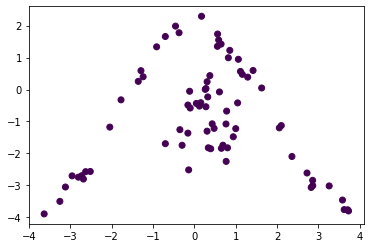

In [10]:
plt.scatter(X_test[:,0], X_test[:, 1], c=svm_pre)
plt.show()

### Task 1.3

- Instead of using the Gaussian RBF kernel, use the linear kernel (dot product) defined in Practical 3.
- Compare results on with both kernels with sklearn implementation (SVC)
- Visualize the predictions on the test set, the learned support vectors and the decision boundary for both kernels.

In [11]:
def linear_kernel(a, b):
    return a.dot(b)

In [12]:
# Fit SVM with linear kernel and calculate the test accuracy
svm_fit = fit_svm(X_train, t_train, linear_kernel)
parameters = extract_parameters(X_train, t_train, linear_kernel, svm_fit)
svm_pre = svm_predict(X_test, linear_kernel, *parameters)
print('Accuarcy:', np.mean(svm_pre == t_test))

     pcost       dcost       gap    pres   dres
 0: -6.8000e+01 -2.4300e+02  7e+02  1e+00  7e-16
 1: -5.6592e+01 -1.2007e+02  7e+01  1e-02  5e-16
 2: -6.6796e+01 -6.9414e+01  3e+00  6e-04  4e-16
 3: -6.7988e+01 -6.8014e+01  3e-02  6e-06  3e-16
 4: -6.8000e+01 -6.8000e+01  3e-04  6e-08  3e-16
 5: -6.8000e+01 -6.8000e+01  3e-06  6e-10  3e-16
Optimal solution found.
Accuarcy: 0.5733333333333334


In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Fit SVM using sklearn and calculate the test accuracy
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, t_train)
clf_pred = clf.predict(X_test)
print('Accuarcy:', np.mean(clf_pred == t_test))

Accuarcy: 1.0


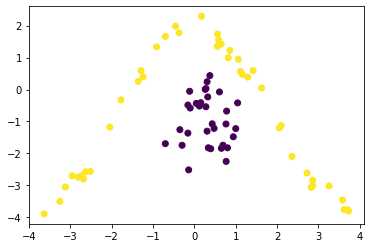

In [14]:
# Visualize
plt.scatter(X_test[:,0], X_test[:, 1], c=clf_pred)
plt.show()

# Task 2: Decision Trees

Next, we will implement a simple decision tree classifier using the Wine dataset, one of the standard sklearn datasets. 

We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split $l_a$ and $l_b$, the weighted removed impurity can be computed by $G(l) - \frac{|l_a|}{|l|}G(l_a) - \frac{|l_b|}{|l|}G(l_b)$.

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


### Task 2.1

1. Plot the distribution of the first feature of for each class of the wine dataset.
2. Implement a function `gini_impurity(t)` that computes the Gini impurity for an array of labels `t`.
3. Calculate the removed Gini impurity for a split after 50 samples, i.e. between `t[:50]` and `t[50:]`.

In [15]:
# Load Wine dataset and split into train+test set
from sklearn.datasets import load_wine
X, t = load_wine(return_X_y=True)
t_train, t_test, X_train, X_test = split_data(X, t)

C:\Users\rene-\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rene-\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rene-\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

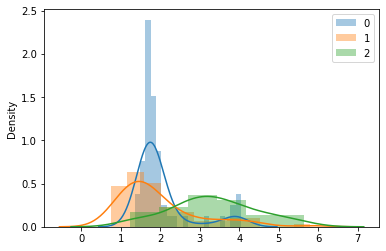

In [16]:
# Plot distribution
import seaborn as sns
for i in np.unique(t):
    sns.distplot(X[(t==i)][:,1],kde=1,label='{}'.format(i))

plt.legend()
plt.show()

In [17]:
# Compute Gini impurity
def gini_impurity(data):
    temp = 0
    for i in np.unique(data):
        temp += np.sum(t==i)/len(t) * (1- np.sum(t==i)/len(t))
    return temp

In [18]:
print('Gini of full dataset: ', gini_impurity(t))
print('Gini of split dataset: ', gini_impurity(t[50:]))
print('Gini of split dataset: ', gini_impurity(t[:50]))
print('Gini of split dataset: ', gini_impurity(t[len(t)-50:]))

Gini of full dataset:  0.6583133442747128
Gini of split dataset:  0.6583133442747128
Gini of split dataset:  0.2215944956444893
Gini of split dataset:  0.4367188486302235


### Task 2.2
Split the data along the first 12 features and plot the removed Gini impurity at different values of this feature. Which is the optimal split?

In [19]:
# Vereinfacher durch pandas:
import pandas as pd
X = pd.DataFrame(X)
t = pd.Series(t)

In [20]:
def splittest(wert, zeile, y):
    links, rechts = list(), list()
    n = len(zeile)
    for i in range(n):
        if zeile[i] < wert:
            links.append(int(y[i]))
        else:
            rechts.append(int(y[i]))
    # For format reasons:
    links, rechts = np.array(links), np.array(rechts)

    return links, rechts

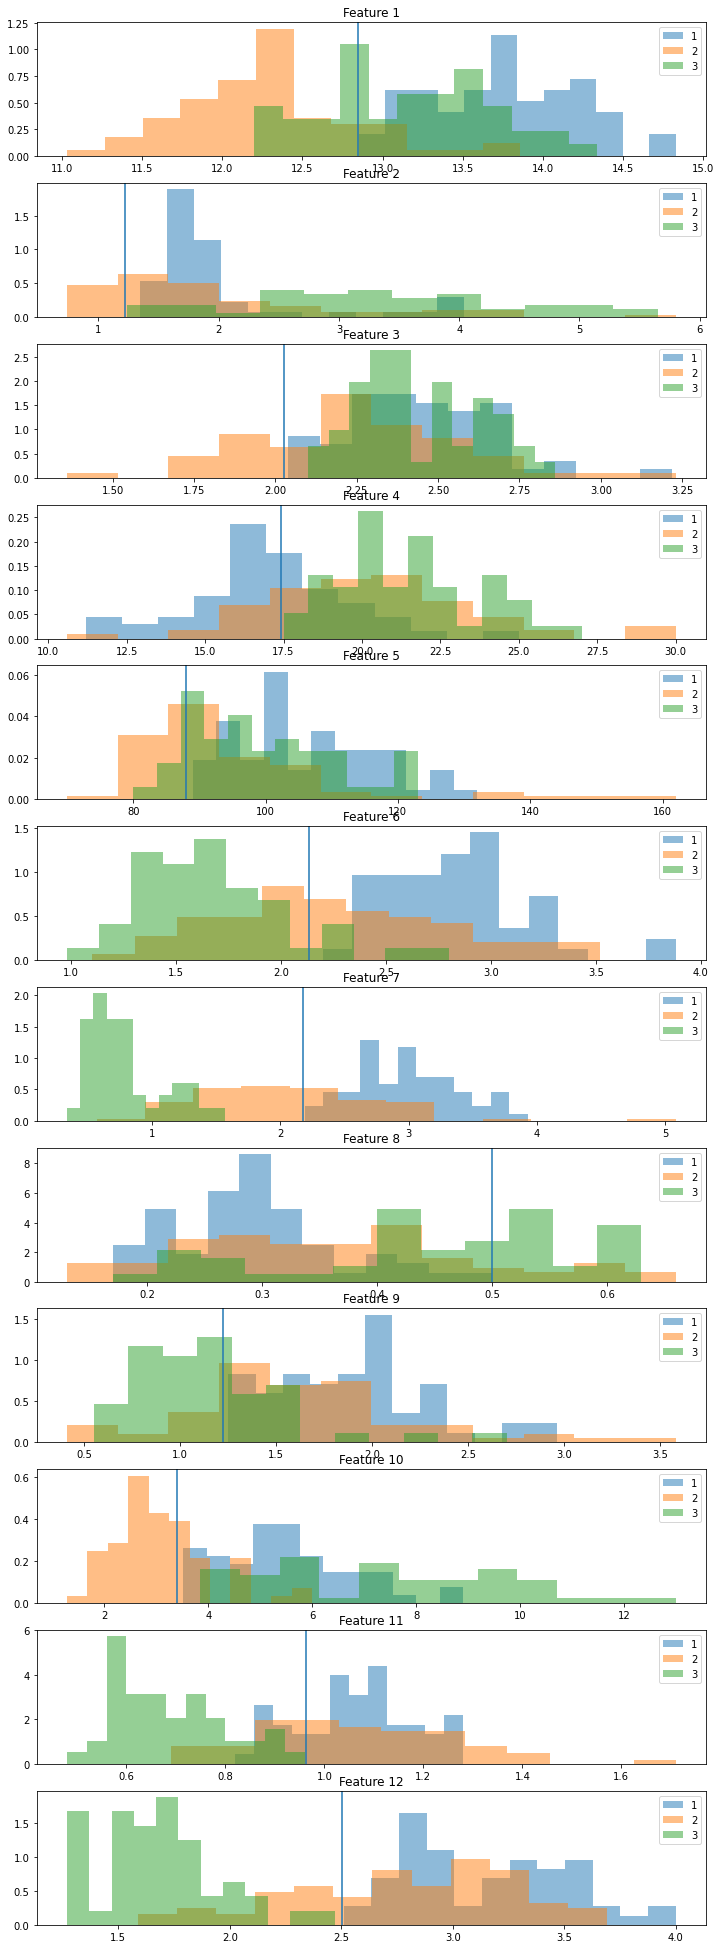

In [21]:
fig, ax = plt.subplots(12, figsize = (12, 35))
for i in range(12):
    x_min, x_max = min(X.iloc[:, i]), max(X.iloc[:, i])
    x_range = np.linspace(start=x_min, stop=x_max, num=200)
    n, _ = X.shape
    bester_split, bester_gini = 0.0, 1.0
    for j in range(len(x_range)):
        links, rechts = splittest(wert = x_range[j], zeile=X.iloc[:, i], y=t) # Aufteilen
        links_gini, rechts_gini = gini_impurity(links), gini_impurity(rechts) #Gini für beide Splits
        weighted_gini = (len(links)/n)*links_gini + (len(rechts)/n)*rechts_gini # Gewichteter Gini
        if weighted_gini < bester_gini: # iteratives zuweisen
            bester_gini, bester_split = weighted_gini, x_range[j]
            bester_left, bester_right = links, rechts

    temp_ax = ax[i]
    feature1 = X.loc[t == 0, i]
    temp_ax.hist(feature1, alpha=0.5, bins=12, density=True, label = '1')
    feature2 = X.loc[t == 1, i]
    temp_ax.hist(feature2, alpha=0.5, bins=12, density=True, label = '2')
    feature3 = X.loc[t == 2, i]
    temp_ax.hist(feature3, alpha=0.5, bins=12, density=True, label = '3')
    temp_ax.axvline(x=bester_split)
    temp_ax.legend()
    name = 'Feature '
    name += str(i+1)
    temp_ax.set_title(name)

### Task 2.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.
3. Switch back to the synthetic 2d dataset from the beginning (kernel methods). Compute scores and visualize the decisions in a 2d grid.

In [22]:
class Node:
    def __init__(self, links, rechts, n_feat, thresholdold):
        self.links = links
        self.rechts = rechts
        self.n_feat = n_feat
        self.thresholdold = thresholdold
    # Funktion um Format ausgeben zu können
    def desc(self):
      return(self.n_feat, self.thresholdold)
    # Folgt ein Split/Child Node?
    def followingSplits(self):
      return True
    # Prediction Function:
    def predict_tree(self, x):
      print(self.followingSplits())
      if(self.followingSplits()):
        feat_n, threshold = self.desc()
        feat_x = x[feat_n]
        if(feat_x < threshold):
          return self.links.predict_tree(x)
        else:
          return self.rechts.predict_tree(x)
      else:
        return self.desc()

In [23]:
class Leaf:
    def __init__(self, label):
        self.label = label
    # braucht man erst für die plots wirklich
    def desc(self):
      return(self.label)
    # Um zu stoppen
    def followingSplits(self):
      return False


In [24]:
def treeplot(node, x=[]):
    # cutoff points for plots
  if node.followingSplits():
    x.append(node.desc())
    if node.links is not None:
      treeplot(node.links,x)
    if node.rechts is not None:
      treeplot(node.rechts,x)

In [25]:
def build_tree(X, t, depth, max_depth=3, n_labels=2):
    # wegen: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'
    if len(X) <=0:
      return
    if len(X)<= 1:
      return Leaf(np.argmax(np.bincount(t)))
    if depth == max_depth:
      return Leaf(np.argmax(np.bincount(t)))

    #start werte
    current_gini, temp_feat, current_split = 1, None , 0.0
    for i in range(X.shape[1]):
      x_min, x_max = min(X.iloc[:, i]), max(X.iloc[:, i])
      x_range = np.linspace(start=x_min, stop=x_max, num=200)
      n = X.shape[0]

      for j in range(len(x_range)):
          links, rechts = splittest(wert = x_range[j], zeile=X.iloc[:, i], y=t) # split column into links and rechts
          links_gini, rechts_gini = gini_impurity(links), gini_impurity(rechts)  # calculate gini coef for links and rechts
          weighted_gini = (len(links)/n)*links_gini + (len(rechts)/n)*rechts_gini # calculate wighted gini
          if weighted_gini < current_gini:  # save best gini 
              current_gini, current_split = weighted_gini, x_range[j]
              temp_links, temp_rechts, temp_feat = links, rechts, i

    links_X, rechts_X = [], []

    for k in range(X.shape[0]): # fröhliches iterieren
      if X.iloc[k,temp_feat] < current_split:
        links_X.append(X.iloc[k,:])
      else:
        rechts_X.append(X.iloc[k,:])

    node = Node(None,None,temp_feat,current_split)  # node class nutzen
    node.links = build_tree(pd.DataFrame(np.array(links_X)), temp_links, depth+1, max_depth, n_labels)
    node.rechts = build_tree(pd.DataFrame(np.array(rechts_X)), temp_rechts, depth+1, max_depth, n_labels)    
    
    return node

In [26]:
def predict_tree(node, x):
  if(node.followingSplits()):
    feat_n, threshold = node.desc()
    feat_x = x[feat_n]
    if(feat_x < threshold):
      return predict_tree(node.links, x)
    else:
      return predict_tree(node.rechts, x)
  else:
      return node.desc()  

In [27]:
def split_data(X, y, frac=0.3, max_samples=None, seed=4711):

    if seed is not None:
        np.random.seed(seed)

    indices = np.random.permutation(len(X))
    indices = indices[:max_samples]
    indices_test, indices_train = indices[:int(len(indices)*frac)], indices[int(len(indices)*frac):]

    assert (len(set(indices))) == len(indices)
    assert len(set(indices_test).intersection(indices_train)) == 0
    
    X_train, X_test = X[indices_train], X[indices_test]
    y_train, y_test = y[indices_train], y[indices_test]
    
    return X_train, X_test, y_train, y_test

In [28]:
X, t = load_wine(return_X_y=True)
X_train, X_test, t_train, t_test = split_data(X = X, y = t)

In [29]:
tree = build_tree(pd.DataFrame(X_train),t_train, 0, max_depth=3, n_labels=3)

In [30]:
count = 0
for i in range(len(X_test)):
  if(t_test[i] == predict_tree(tree, X_test[i])):
    count += 1


In [31]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, t_train)
predsk = clf.predict(X_test)
skcounter = 0
for i in range(len(predsk)):
  if(predsk[i] == t_test[i]):
    skcounter += 1 

In [32]:
print("sklearn score:", skcounter/len(t_test))
print("Our score:", (count)/len(t_test))

sklearn score: 0.9245283018867925
Our score: 0.8679245283018868


In [33]:
X_2d, t_2d = np.load('data/nonlin_2d_data.npy')[:,:2], np.load('data/nonlin_2d_data.npy')[:, 2]
X_train, X_test, y_train, y_test = split_data(X_2d, t_2d)
y_train = y_train.astype(int)

In [34]:
tree = build_tree(pd.DataFrame(X_train),y_train, 0, max_depth=3, n_labels=2)

In [35]:
correct = 0
for i in range(len(X_test)):
  if(y_test[i] == predict_tree(tree, X_test[i])):
    correct += 1
print(correct/len(y_test))

0.9866666666666667


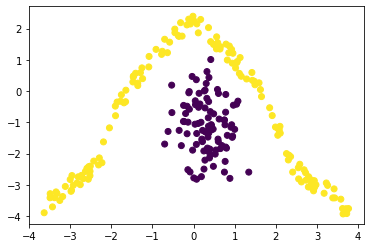

In [36]:
fig, ax = plt.subplots()
plt.scatter(X_2d[:,0], X_2d[:, 1], c=t_2d)
plt.show()

In [37]:
cutoff = []
treeplot(tree, cutoff)
print(cutoff)

[(0, -0.7324396890211675), (0, -3.4892727654203752), (0, -3.633659394608522), (0, -2.555753841389027), (0, 1.363874427471301), (1, 0.38410063742834977), (0, 2.32758430160215)]


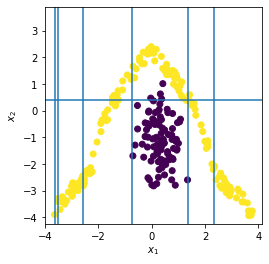

In [38]:
fig, ax = plt.subplots()
plt.scatter(X_2d[:,0], X_2d[:, 1], c=t_2d)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
#ax.axhline(y=1)
for i in cutoff:
  if i[0]:
    ax.axhline(y=i[1])
  else:
    ax.axvline(x=i[1])